# **Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


# **Loading the dataset**

In [2]:
file_path = "Australia real estate properties.csv"
df = pd.read_csv(file_path, low_memory=False)

print(f"Original dataset shape: {df.shape}")
# Displaying shape and preview
print("Shape of dataset:", df.shape)
df.head()


Original dataset shape: (1000, 43)
Shape of dataset: (1000, 43)


,rea_property_id,property_type,state,postcode,year_built,last_sold_date,last_sold_agency,bedrooms,bathrooms,findAgentsURI,...,listing_type,availability,rent_price,rent_bond,rent_currency,sold_date,property_history_link,description,agents,branding
0,property-house-vic-cowes-143221916,NaN,VIC,3922.0,NaN,NaN,Ray White - Phillip Island,4.0,2.0,https://www.realestate.com.au/agency/ray-white...,...,Sold,NaN,NaN,NaN,AUD,2023-11-23T00:00:00.000Z,https://www.realestate.com.au/property/20-dafy...,Nestled in the highly sought-after enclave of ...,"[{""comapny_link"":""https://www.realestate.com.a...",large
1,property-house-act-theodore-122604874,NaN,ACT,2905.0,NaN,NaN,McIntyre Property,5.0,3.0,https://www.realestate.com.au/agency/mcintyre-...,...,Sold,NaN,NaN,NaN,AUD,2016-08-02T00:00:00.000Z,https://www.realestate.com.au/property/77-scan...,Well I can give you the space you need here......,"[{""comapny_link"":""https://www.realestate.com.a...",medium
2,property-house-nsw-marsden+park-129588550,NaN,NSW,2765.0,NaN,NaN,Professionals Homepoint Realty - RIVERSTONE,4.0,2.0,https://www.realestate.com.au/agency/professio...,...,Sold,NaN,NaN,NaN,AUD,2019-03-29T00:00:00.000Z,https://www.realestate.com.au/property/12-atki...,SOLD BY GLENN HAGAN!New designer home in popul...,"[{""comapny_link"":""https://www.realestate.com.a...",NaN
3,property-house-qld-yeerongpilly-106087680,NaN,QLD,4105.0,NaN,NaN,REMAX Results - Morningside,5.0,3.0,https://www.realestate.com.au/agency/remax-res...,...,Sold,NaN,NaN,NaN,AUD,2009-11-14T00:00:00.000Z,https://www.realestate.com.au/property/51-nath...,Alive with period character features that blen...,"[{""comapny_link"":""https://www.realestate.com.a...",NaN
4,6486894,House,Qld,4680.0,NaN,2020-12-14T00:00:00.000Z,Elders - Gladstone and Tannum Sands,3.0,2.0,NaN,...,History,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Filter for Victoria (Melbourne) data only**

In [3]:
df = df[df['state'].str.upper() == 'VIC']
print(f"Filtered VIC data shape: {df.shape}")


Filtered VIC data shape: (243, 43)


# **Identifying the target variable**

In [4]:
target_col_candidates = ['sold_price', 'sale_price', 'last_sold_price', 'estimated_price']
target_col = None

for col in target_col_candidates:
    if col in df.columns:
        target_col = col
        print(f"Using target column: {target_col}")
        break

if target_col is None:
    raise ValueError("No suitable target column found!")


Using target column: estimated_price


# **Data Cleaning & Preprocessing**

In [5]:
# Dropping irrelevant columns that won't help prediction or cause leakage
cols_to_drop = [
    'rea_property_id', 'findAgentsURI', 'images_urls', 'property_history_link',
    'url', 'branding', 'agents', 'description', 'lat', 'lon', 'fullSuburb',
    'street_address', 'sales_history', 'availability'
]

# Dropping columns not in df.columns safely
cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df.drop(columns=cols_to_drop, inplace=True)

# Cleaning target column
if df[target_col].dtype == 'object':
    df[target_col] = df[target_col].str.extract(r'(\d[\d,\.]*)')[0]
    df[target_col] = df[target_col].str.replace(',', '', regex=False)
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

# Dropping rows with missing target
df = df.dropna(subset=[target_col])
df['suburb_median_price'] = df.groupby('suburb')[target_col].transform('median')

# Converting numeric columns, fill missing values with median
numeric_cols = ['bedrooms', 'bathrooms', 'land_size_num', 'floor_area_num', 'year_built']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


# **EDA Visuals**

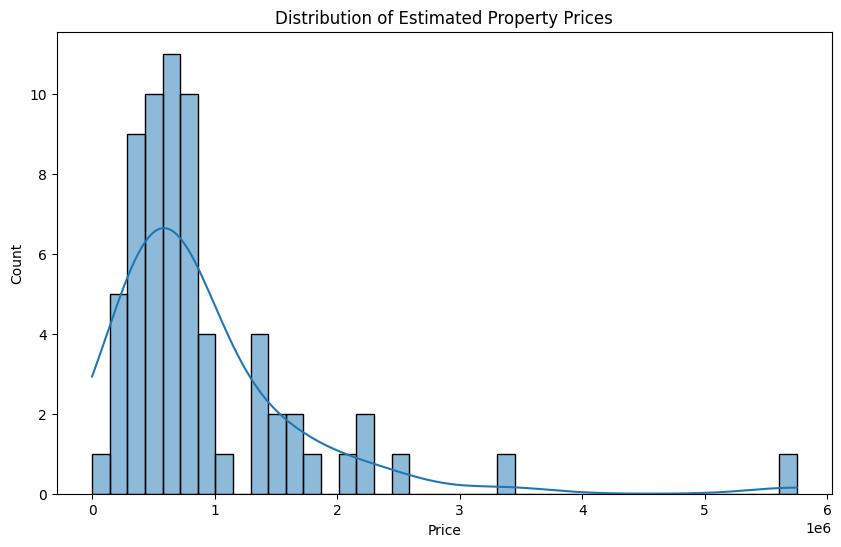

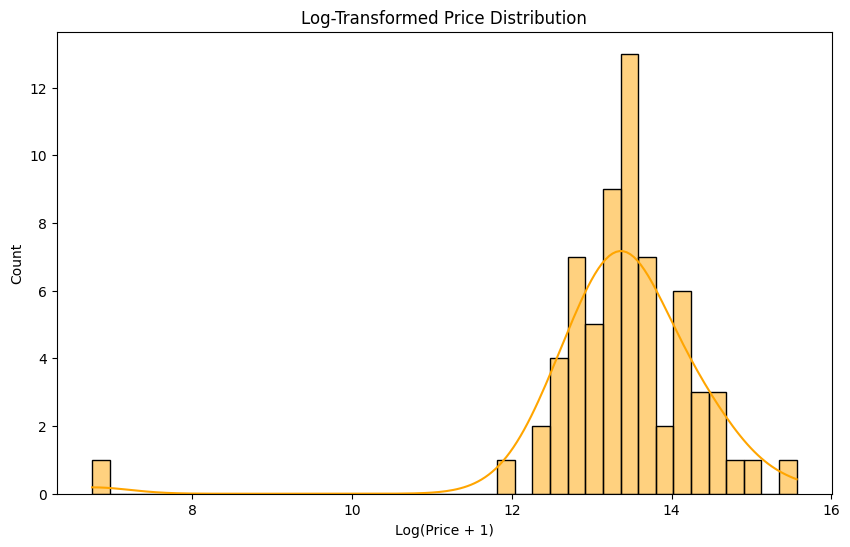

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['estimated_price'], kde=True, bins=40)
plt.title("Distribution of Estimated Property Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

# Log transformation to reduce skew
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['estimated_price']), kde=True, bins=40, color='orange')
plt.title("Log-Transformed Price Distribution")
plt.xlabel("Log(Price + 1)")
plt.ylabel("Count")
plt.show()


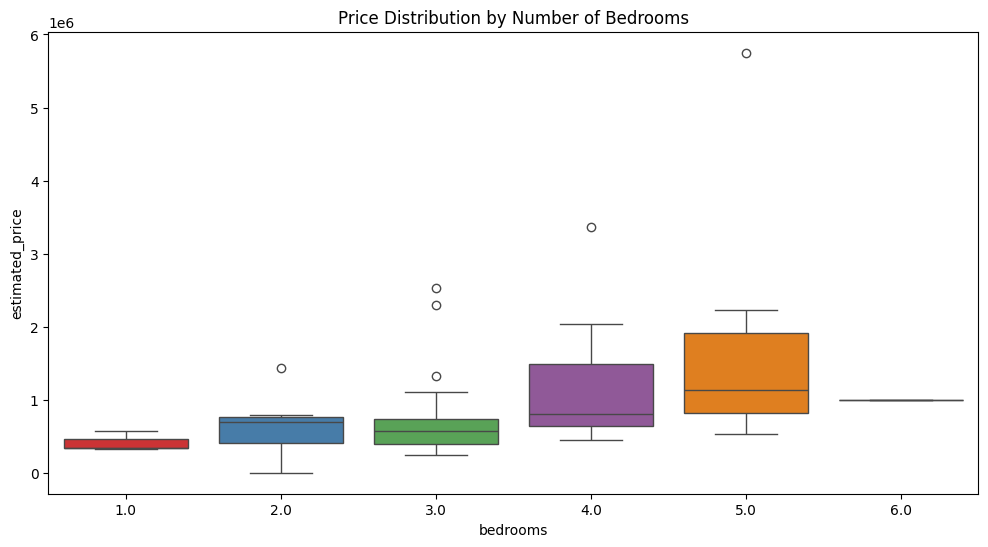

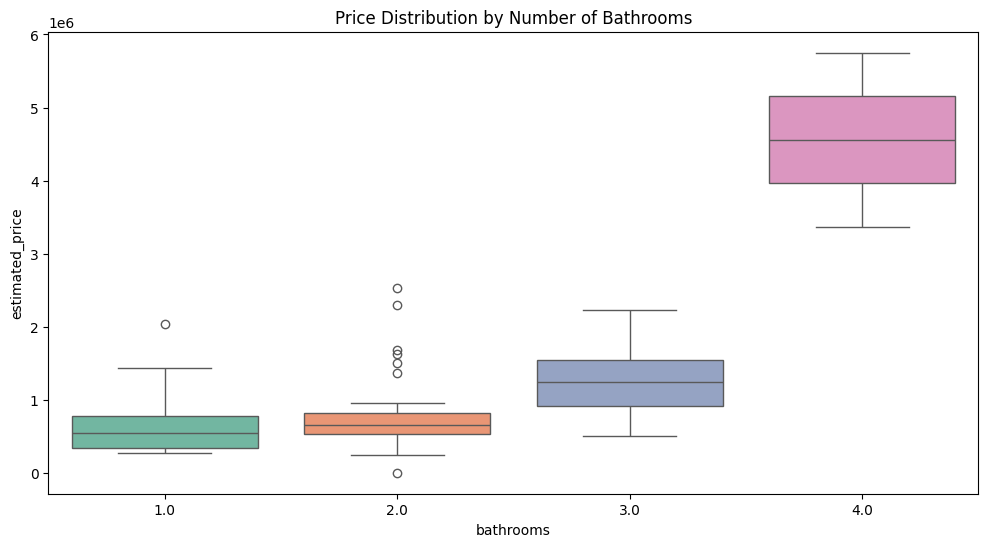

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='bedrooms', y='estimated_price', palette="Set1")
plt.title("Price Distribution by Number of Bedrooms")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='bathrooms', y='estimated_price', palette="Set2")
plt.title("Price Distribution by Number of Bathrooms")
plt.show()


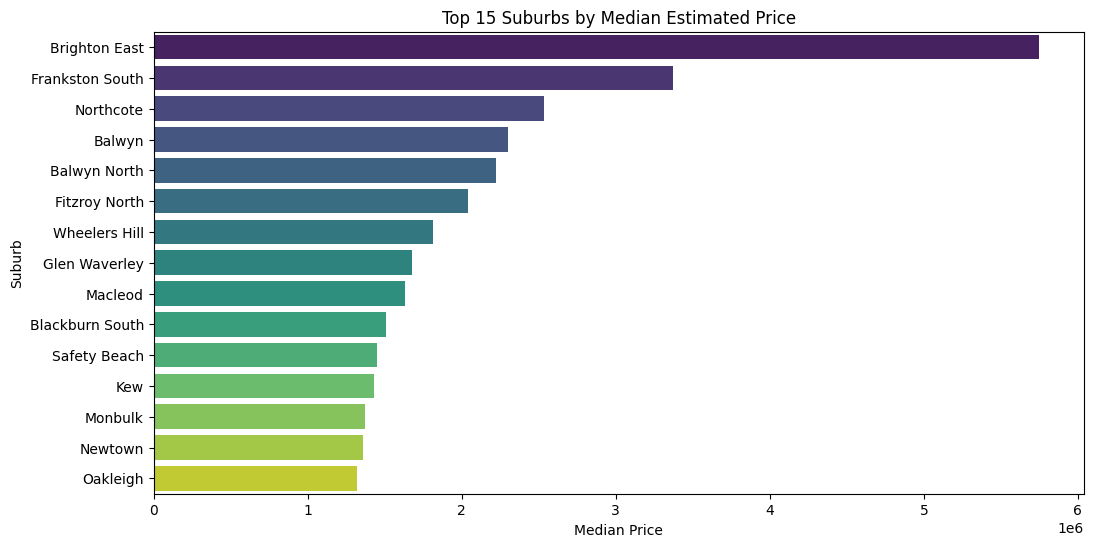

In [8]:
top_suburbs = df.groupby('suburb')['estimated_price'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_suburbs.values, y=top_suburbs.index, palette='viridis')
plt.title("Top 15 Suburbs by Median Estimated Price")
plt.xlabel("Median Price")
plt.ylabel("Suburb")
plt.show()


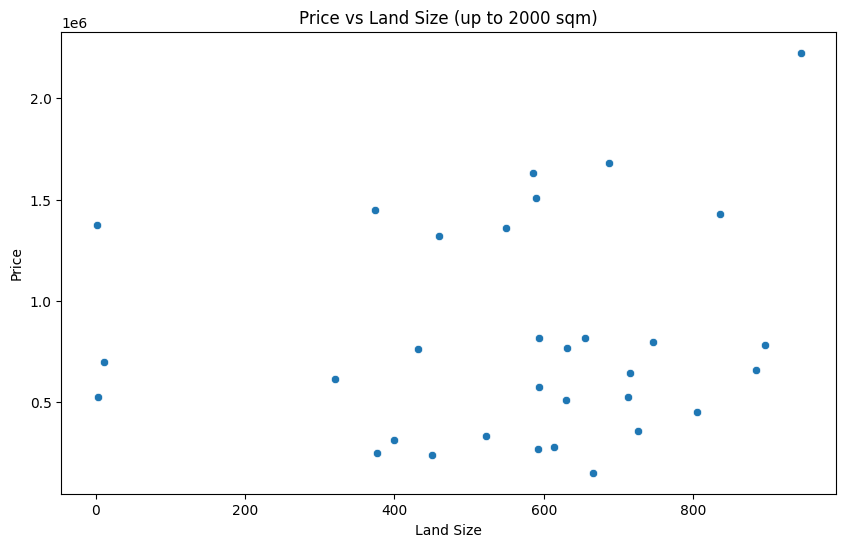

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df[df['land_size_num'] < 2000], x='land_size_num', y='estimated_price')
plt.title("Price vs Land Size (up to 2000 sqm)")
plt.xlabel("Land Size")
plt.ylabel("Price")
plt.show()


# **Feature Engineering**

In [10]:
# Building age = Current Year (assumed 2025) - year_built
df['building_age'] = 2025 - df['year_built']
df.loc[df['building_age'] == 2025, 'building_age'] = np.nan  # replace invalid ages
df['building_age'] = df['building_age'].fillna(df['building_age'].median())

# Including key numerical and categorical features
features = [
    'bedrooms', 'bathrooms', 'land_size_num', 'floor_area_num',
    'building_age', 'suburb_median_price', 'suburb', 'property_type', 'house_type'
]

# Keeping only features present in df
features = [f for f in features if f in df.columns]

# Preparing X and y
X = df[features]
y = df[target_col]

print(f"Final dataset shape: X={X.shape}, y={y.shape}")
df['suburb_median_price'] = df.groupby('suburb')[target_col].transform('median')

# Separating features by type
numeric_features = ['bedrooms', 'bathrooms', 'land_size_num', 'floor_area_num', 'suburb_median_price', 'building_age']
numeric_features = [f for f in numeric_features if f in X.columns]

categorical_features = ['suburb', 'property_type', 'house_type']
categorical_features = [f for f in categorical_features if f in X.columns]


Final dataset shape: X=(66, 9), y=(66,)


# **Target transformation (log-transform to reduce skewness)**

In [11]:
def log_transform(y):
    return np.log1p(y)

def inverse_log_transform(y):
    return np.expm1(y)

# Transforming target
y_transformed = log_transform(y)

# Defining preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical, using OneHotEncoding with handle_unknown='ignore' to avoid errors on test data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


# **Defining models to compare**

In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)


# **Training models in pipelines and evaluate**

In [13]:
results = {}

for name, model in models.items():
    print(f"Training and evaluating model: {name}")

    # Creating pipeline with preprocessing and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])

    # Cross-validation (5-fold) on training set
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    neg_mae_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    mae_cv = -neg_mae_scores.mean()
    print(f"CV Mean MAE (log scale): {mae_cv:.4f}")

    # Fitting on full training data
    pipeline.fit(X_train, y_train)

    # Predicting on test data
    y_pred_log = pipeline.predict(X_test)

    # Inverse log transform predictions and actuals
    y_pred = inverse_log_transform(y_pred_log)
    y_true = inverse_log_transform(y_test)

    # Evaluating metrics on original scale
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"Test MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}\n")

    results[name] = {'CV_MAE_log': mae_cv, 'Test_MAE': mae, 'Test_RMSE': rmse, 'Test_R2': r2}
    # Store pipeline for later use if needed
    results[name]['pipeline'] = pipeline


Training and evaluating model: Linear Regression
CV Mean MAE (log scale): 0.9803
Test MAE: 263926.42, RMSE: 310649.42, R²: 0.7482

Training and evaluating model: Decision Tree
CV Mean MAE (log scale): 0.2256
Test MAE: 160082.50, RMSE: 313787.71, R²: 0.7431

Training and evaluating model: Random Forest
CV Mean MAE (log scale): 0.2362
Test MAE: 58286.69, RMSE: 87694.95, R²: 0.9799

Training and evaluating model: SVR
CV Mean MAE (log scale): 0.4620
Test MAE: 207576.68, RMSE: 268088.79, R²: 0.8125

Training and evaluating model: XGBoost
CV Mean MAE (log scale): 0.3281
Test MAE: 71583.13, RMSE: 110454.64, R²: 0.9682



# **Displaying all results in a table**

In [14]:
results_df = pd.DataFrame(results).T.drop(columns=['pipeline'])
print("Model Comparison Results:")
print(results_df.sort_values('Test_MAE'))


Model Comparison Results:
                  CV_MAE_log       Test_MAE      Test_RMSE   Test_R2
Random Forest       0.236224   58286.686097   87694.950372  0.979936
XGBoost             0.328085   71583.131696  110454.641049   0.96817
Decision Tree       0.225649       160082.5  313787.705535  0.743115
SVR                 0.462018    207576.6751  268088.788401   0.81249
Linear Regression   0.980258  263926.419455  310649.419945  0.748227


# **Hyperparameter tuning for Random Forest and XGBoost with pipeline**

In [15]:
# Function to perform GridSearchCV with pipeline and return best model & results
def tune_model(model_name, base_model, param_grid):
    print(f"\nTuning hyperparameters for {model_name}")

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', base_model)])

    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5,
                               scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

    grid_search.fit(X_train, y_train)
    print(f"Best params for {model_name}: {grid_search.best_params_}")

    # Evaluating best estimator on test set
    y_pred_log = grid_search.best_estimator_.predict(X_test)
    y_pred = inverse_log_transform(y_pred_log)
    y_true = inverse_log_transform(y_test)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} tuned test MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

    return grid_search.best_estimator_, {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Random Forest hyperparameter grid
rf_param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

best_rf_model, rf_metrics = tune_model('Random Forest', RandomForestRegressor(random_state=42), rf_param_grid)

# XGBoost hyperparameter grid
xgb_param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2]
}

best_xgb_model, xgb_metrics = tune_model('XGBoost', XGBRegressor(objective='reg:squarederror', random_state=42), xgb_param_grid)



Tuning hyperparameters for Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for Random Forest: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Random Forest tuned test MAE: 58286.69, RMSE: 87694.95, R²: 0.9799

Tuning hyperparameters for XGBoost
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
XGBoost tuned test MAE: 103691.82, RMSE: 156179.39, R²: 0.9364


# **Feature importance from best RF and XGB models**


Feature Importances for Tuned Random Forest:


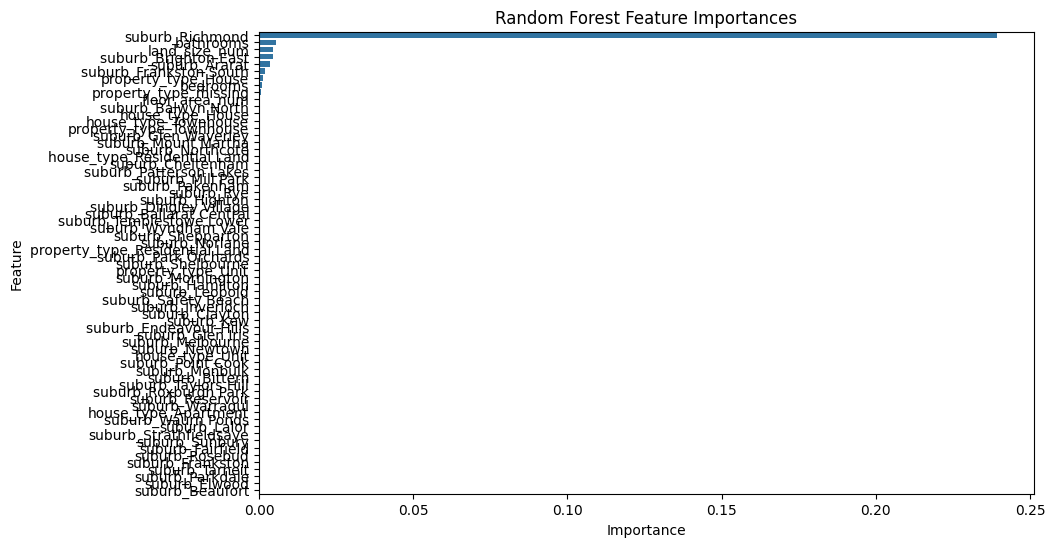


Feature Importances for Tuned XGBoost:


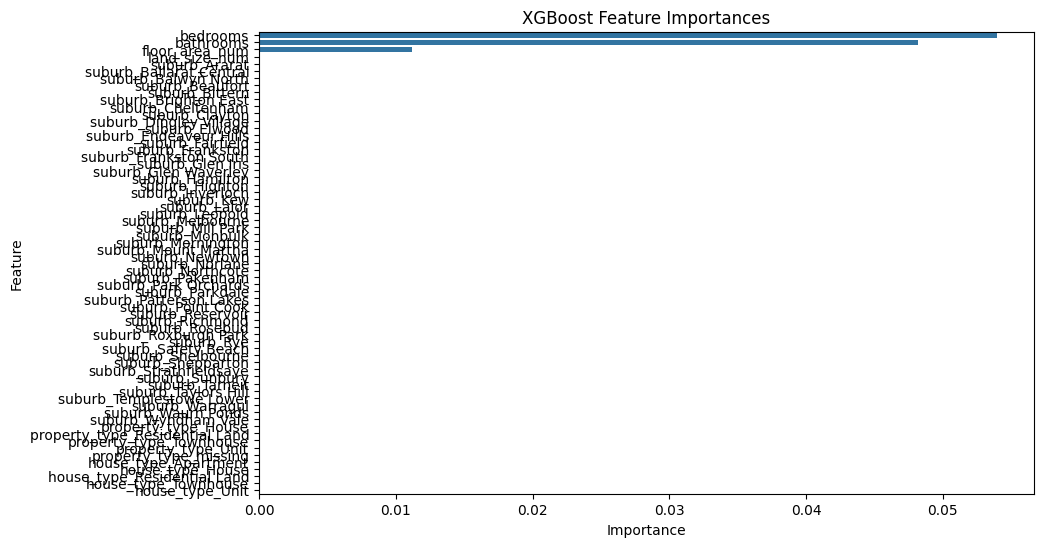

In [16]:
def plot_feature_importance(model_pipeline, model_name):
    preprocessor = model_pipeline.named_steps['preprocessor']
    model = model_pipeline.named_steps['regressor']

    # Function to get feature names from the preprocessor
    def get_feature_names(preprocessor):
        feature_names = []
        for name, transformer, columns in preprocessor.transformers_:
            if name == 'remainder' and transformer == 'passthrough':
                feature_names.extend(columns)
            elif hasattr(transformer, 'get_feature_names_out'):
                names = transformer.get_feature_names_out(columns)
                feature_names.extend(names)
            else:
                feature_names.extend(columns)
        return feature_names

    feature_names = get_feature_names(preprocessor)

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=feature_names)

        feat_imp = feat_imp.drop(labels=[col for col in feat_imp.index if 'suburb_median_price' in col], errors='ignore')
        feat_imp = feat_imp.sort_values(ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=feat_imp.values, y=feat_imp.index)
        plt.title(f"{model_name} Feature Importances")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()
    else:
        print(f"{model_name} does not support feature importances.")

print("\nFeature Importances for Tuned Random Forest:")
plot_feature_importance(best_rf_model, "Random Forest")

print("\nFeature Importances for Tuned XGBoost:")
plot_feature_importance(best_xgb_model, "XGBoost")


# **Residual analysis for best model (choosing best by Test MAE)**


Residual plot for best model: Random Forest


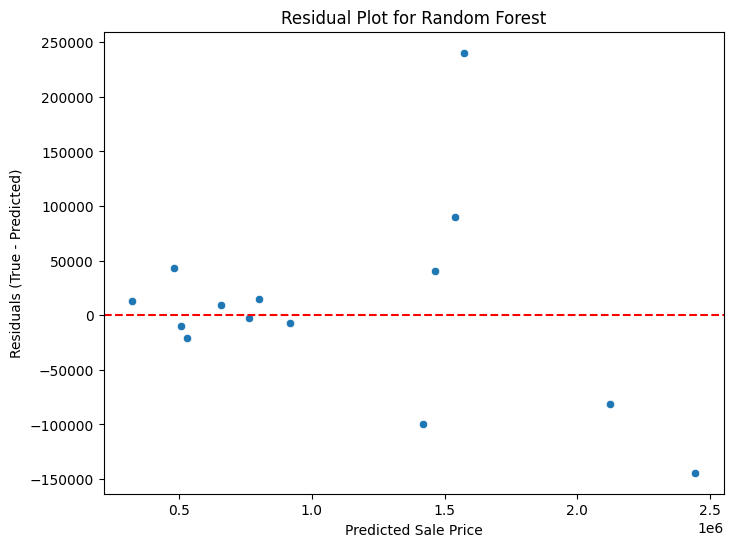

In [17]:
best_model_name = min(results, key=lambda k: results[k]['Test_MAE'])
best_pipeline = results[best_model_name]['pipeline']

print(f"\nResidual plot for best model: {best_model_name}")

# Predicting on test set
y_pred_log = best_pipeline.predict(X_test)
y_pred = inverse_log_transform(y_pred_log)
y_true = inverse_log_transform(y_test)
residuals = y_true - y_pred

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals (True - Predicted)')
plt.title(f'Residual Plot for {best_model_name}')
plt.show()


In [ ]:
import joblib

# Save best model pipeline
joblib.dump(best_rf_model, 'best_model.pkl')


['best_model.pkl']